### 02 - Real Space Reconnstruction

This document details the three core stages of Pipeline A, which evaluates a pretrained U-Net model's ability to reconstruct undersampled magnetic resonance (MR) images. The target image is always the fully sampled ground truth.

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
import os 
import matplotlib.pyplot as plt

from fastmri.data.transforms import center_crop, center_crop_to_smallest
from fastmri import ifft2c, complex_abs


project_root = Path('..').resolve()
project_root_str = str(project_root)


if project_root_str not in sys.path:
    # Use insert(0) to ensure it's the first place Python checks
    sys.path.insert(0, project_root_str)
    print(f"Added '{project_root_str}' to sys.path.")

import importlib
import src.datasets 
import src.models
import src.evaluation_utilities
importlib.reload(src.datasets)
importlib.reload(src.models)
importlib.reload(src.evaluation_utilities)
from src.datasets import RealSpaceReconDataset 
from src.models import load_fastmri_unet
from src.evaluation_utilities import calculate_metrics, visualize_metrics

np.random.seed(42)

Added 'C:\Users\Anna Lyamkina\OneDrive\Documents\Portfolio\fastMRI-knee-workflow' to sys.path.


#### 2.1. Testing RealSpaceReconDataset

The pipeline begins by confirming the functionality of the custom data loader, RealSpaceReconDataset. This dataset is designed to yield five critical tensors per sample:

- input_data (Normalized): The undersampled, zero-filled, and Fourier-transformed magnitude image (the network input).

- target_data (Normalized): The fully sampled ground truth magnitude image (the reconstruction target).

- mean (μ): The per-slice mean used for normalization.

- std (σ): The per-slice standard deviation used for normalization.

- max_value: The maximum magnitude value of the original (un-normalized) fully sampled slice.

In [2]:
data_root = Path("../data/raw/singlecoil_val")
train_data_file = Path("../data/labels/train_data.csv")
target_res= (320, 320)
AF = 10

train_dataset = RealSpaceReconDataset(
    manifest_path=train_data_file, 
    data_root=data_root,
    acceleration_factor=AF,
    target_resolution=target_res)
index = 10
masked_img, target_image, mean, std, max_value = train_dataset[index]
# Check shapes and types
print(f"Input (Masked Image) Shape: {masked_img.shape}, dtype: {masked_img.dtype}")
print(f"Target (Full Image) Shape: {target_image.shape}, dtype: {target_image.dtype}")
expected_shape = (1, target_res[0], target_res[1])
print("Expected shape: ", expected_shape)

Input (Masked Image) Shape: torch.Size([1, 320, 320]), dtype: torch.float32
Target (Full Image) Shape: torch.Size([1, 320, 320]), dtype: torch.float32
Expected shape:  (1, 320, 320)


C:\Users\Anna Lyamkina\OneDrive\Documents\Portfolio\fastMRI-knee-workflow\src\datasets.py:227: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean_tensor = torch.tensor(mean, dtype=torch.float32)
C:\Users\Anna Lyamkina\OneDrive\Documents\Portfolio\fastMRI-knee-workflow\src\datasets.py:228: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std_tensor = torch.tensor(std, dtype=torch.float32)
C:\Users\Anna Lyamkina\OneDrive\Documents\Portfolio\fastMRI-knee-workflow\src\datasets.py:229: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_value_tenso

We now visualize the images returned by the instance of RealSpaceReconDataset.

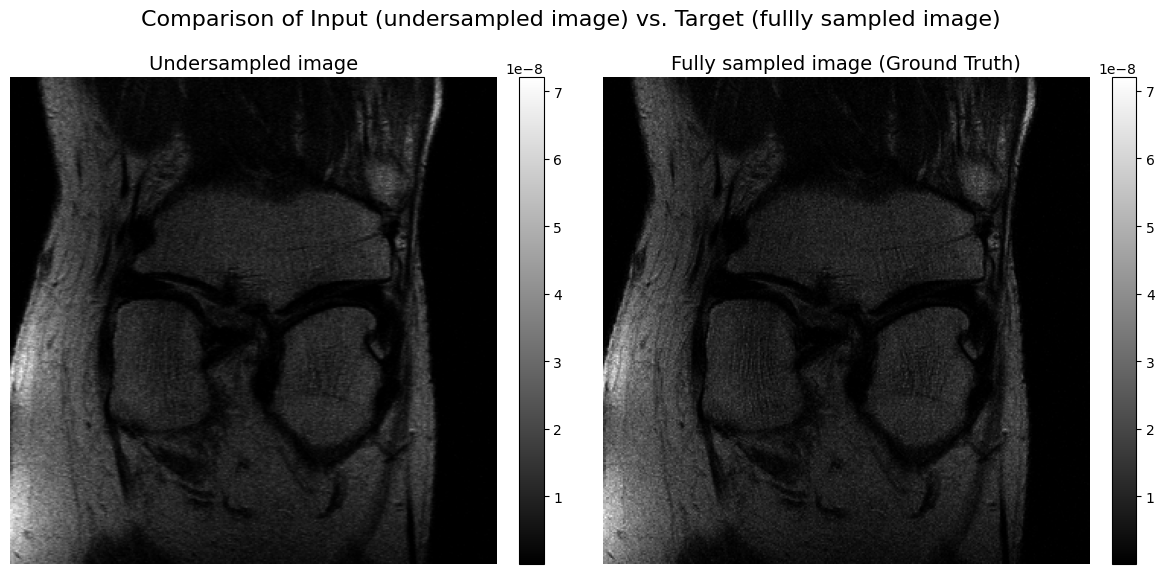

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

im1 = axes[0].imshow(masked_img[0]*max_value, cmap='gray')
axes[0].set_title("Undersampled image", fontsize=14)
axes[0].axis('off')

fig.colorbar(im1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

im2 = axes[1].imshow(target_image[0]*std + mean, cmap='gray')
axes[1].set_title("Fully sampled image (Ground Truth)", fontsize=14)
axes[1].axis('off')

fig.colorbar(im2, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

fig.suptitle("Comparison of Input (undersampled image) vs. Target (fullly sampled image)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

Data loading works as expected.We can now proceed with modelling.

#### 2.2 Pretrained model from fastMRI project

In this project we will use a fully pretrained U-net model to reconstruct real space images. The function download_model and corresponding url and model names are acquired from from the official fastMRI github repository:

https://github.com/facebookresearch/fastMRI/blob/main/fastmri_examples/unet/run_pretrained_unet_inference.py

The download_model utility was adjusted to check if the model weights are downloaded locally. Afterwards the U-Net architecture is instantiated and loaded with these weights.

In [4]:
import requests
import os
from tqdm import tqdm 

weights_folder = Path("../models/pretrained")

UNET_FOLDER = "https://dl.fbaipublicfiles.com/fastMRI/trained_models/unet/"

MODEL_FNAMES = {
    "unet_knee_sc": "knee_sc_leaderboard_state_dict.pt",
    "unet_knee_mc": "knee_mc_leaderboard_state_dict.pt",
    "unet_brain_mc": "brain_leaderboard_state_dict.pt",
}


def download_model(url: str, fname: str):
    """
    Downloads a file from a URL to the specified local path (fname).
    """
    if os.path.exists(fname):
        print(f"✅ Model already exists at: {fname}. Skipping download.")
        return

    target_dir = os.path.dirname(fname)
    if target_dir and not os.path.exists(target_dir):
        os.makedirs(target_dir)
        print(f"Created directory: {target_dir}")

    try:
        response = requests.get(url, timeout=10, stream=True)
        response.raise_for_status() # Raise an exception for bad status codes
    except requests.exceptions.RequestException as e:
        print(f"Error during network request: {e}")
        return

    chunk_size = 1 * 1024 * 1024  # 1 MB chunks
    total_size_in_bytes = int(response.headers.get("content-length", 0))
    
    progress_bar = tqdm(
        desc=f"Downloading {os.path.basename(fname)}",
        total=total_size_in_bytes,
        unit="iB",
        unit_scale=True,
    )

    with open(fname, "wb") as fh:
        for chunk in response.iter_content(chunk_size):
            progress_bar.update(len(chunk))
            fh.write(chunk)

    progress_bar.close()
    print(f"\nSuccessfully downloaded model to: {fname}")


file_name = MODEL_FNAMES["unet_knee_sc"]
download_url = UNET_FOLDER + file_name
weights_filepath = weights_folder/file_name

download_model(url=download_url, fname=weights_filepath)
unet = load_fastmri_unet(weights_path=weights_filepath)
unet.eval()

✅ Model already exists at: ..\models\pretrained\knee_sc_leaderboard_state_dict.pt. Skipping download.
Loading U-Net model from: knee_sc_leaderboard_state_dict.pt...
Checkpoint loaded
state loaded


Unet(
  (down_sample_layers): ModuleList(
    (0): ConvBlock(
      (layers): Sequential(
        (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Dropout2d(p=0.0, inplace=False)
        (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (5): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (6): LeakyReLU(negative_slope=0.2, inplace=True)
        (7): Dropout2d(p=0.0, inplace=False)
      )
    )
    (1): ConvBlock(
      (layers): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): 

#### 2.3 Pipeline A evaluation

We will now evaluate the performance of pipeline A by calculating following metrics:

1. Root Mean Squared Error (RMSE)

RMSE is calculated directly on the denormalized prediction and target.

$$ RMSE=\sqrt{\frac{1}{N}\sum_{i=1}^{N}​(Prediction_{denorm,i}​−Target_{denorm,i​})^2} $$

2. Peak Signal-to-Noise Ratio (PSNR)

PSNR is highly sensitive to the defined data range, which is why the max_value (the maximum magnitude of the original ground truth image) is crucial.

$$ PSNR=10⋅log_{10}​(\frac{​(MAX\_VALUE)^2}{MSE_{denorm}}​) $$
​
3. Structural Similarity Index Measure (SSIM)

The Structural Similarity Index Measure (SSIM) is a perceptual metric designed to quantify the perceived quality of a degraded image relative to its original, uncompressed reference. Unlike simple error calculations like PSNR, SSIM models the human visual system by focusing on the three primary components of an image's structure: luminance, contrast, and correlation (structure). The final score is a decimal value between 0 (no similarity) and 1 (perfect similarity), reflecting how visually similar two images are to a human observer.

Similar to PSNR, the SSIM metric must also be calculated with the correct maximum possible pixel value, which is provided by the per-slice max_value. This ensures the SSIM score accurately reflects perceptual quality within the correct dynamic range of the MR image.


The metrics are calculated on the validation set, for a demo we will use a subset of 10 samples. 

**Important Note: Denormalization**

The U-Net model operates entirely on normalized data (where values are centered around zero and scaled by standard deviation). However, standard image quality metrics (RMSE, PSNR, SSIM) must be calculated on the original denormalized magnitude image values to provide meaningful results.

Therefore, before any metric is calculated, both the model's prediction and the ground truth target must be denormalized using the inverse of the μ/σ operation:

$$ Y_{denorm}​=(Y_{norm}​⋅std)+mean $$


C:\Users\Anna Lyamkina\OneDrive\Documents\Portfolio\fastMRI-knee-workflow\src\datasets.py:227: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean_tensor = torch.tensor(mean, dtype=torch.float32)
C:\Users\Anna Lyamkina\OneDrive\Documents\Portfolio\fastMRI-knee-workflow\src\datasets.py:228: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std_tensor = torch.tensor(std, dtype=torch.float32)
C:\Users\Anna Lyamkina\OneDrive\Documents\Portfolio\fastMRI-knee-workflow\src\datasets.py:229: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_value_tenso

Samples processed: 1
Samples processed: 2
Samples processed: 3
Samples processed: 4
Samples processed: 5
Samples processed: 6
Samples processed: 7
Samples processed: 8
Samples processed: 9
Samples processed: 10


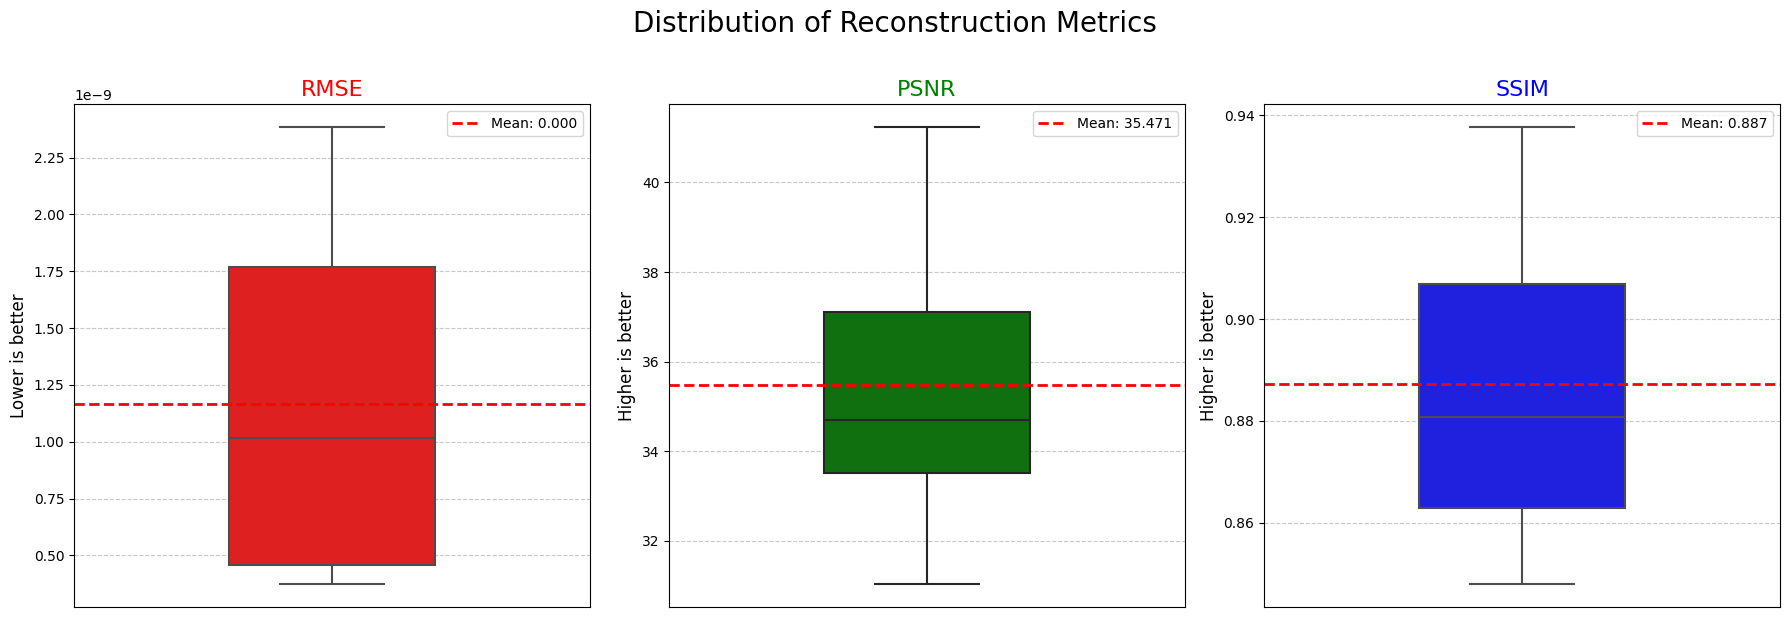

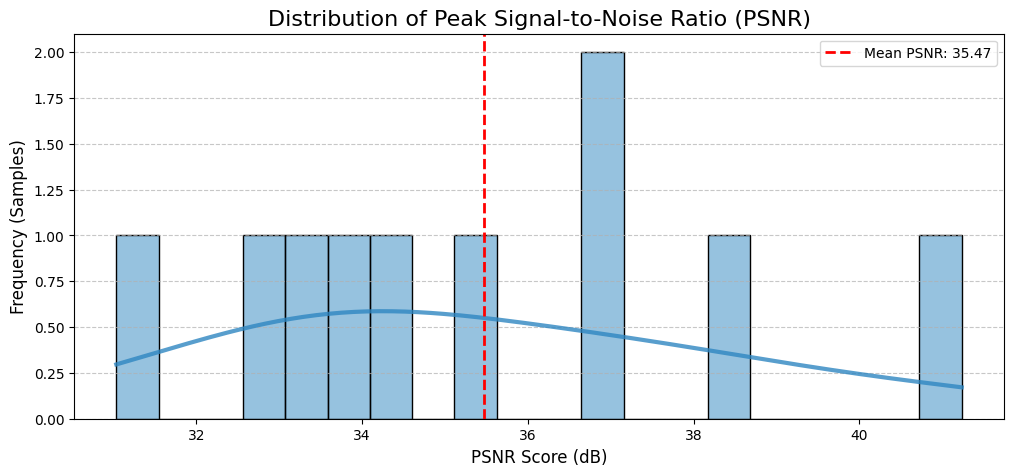

In [5]:
val_data_file = Path("../data/labels/val_data.csv")
validation_dataset = RealSpaceReconDataset(
    manifest_path=val_data_file, 
    data_root=data_root,
    acceleration_factor=AF,
    target_resolution=target_res)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)

all_rmse_scores, all_psnr_scores, all_ssim_scores = calculate_metrics(validation_loader, model=unet, nsamples = 10)
visualize_metrics(all_rmse_scores, all_psnr_scores, all_ssim_scores )

#### 2.4 Final Visualization

The last step provides a qualitative assessment of the reconstruction performance. The following images are displayed side-by-side:

- Undersampled Input: The zero-filled image used as input.

- Reconstructed Image: The U-Net's denormalized output.

- Ground Truth: The fully sampled denormalized target.

This allows for visual confirmation of how closely the reconstructed image matches the ground truth and helps identify common reconstruction artifacts.

C:\Users\Anna Lyamkina\OneDrive\Documents\Portfolio\fastMRI-knee-workflow\src\datasets.py:227: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean_tensor = torch.tensor(mean, dtype=torch.float32)
C:\Users\Anna Lyamkina\OneDrive\Documents\Portfolio\fastMRI-knee-workflow\src\datasets.py:228: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std_tensor = torch.tensor(std, dtype=torch.float32)
C:\Users\Anna Lyamkina\OneDrive\Documents\Portfolio\fastMRI-knee-workflow\src\datasets.py:229: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_value_tenso

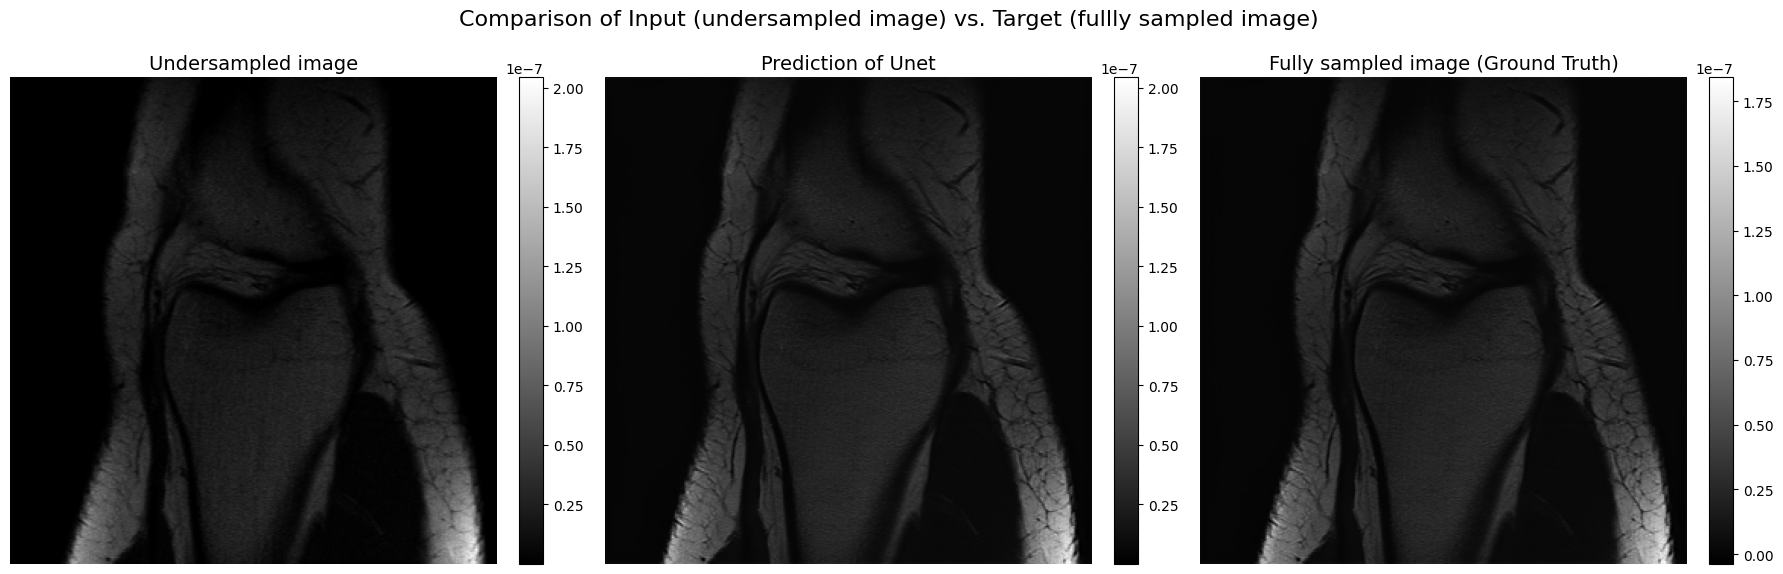

In [6]:
for masked_img2, target_img2, mean, std, max_value in validation_loader:
    break
pred = unet(masked_img2)
pred_denorm = pred*std+mean
target_denorm = pred*std+mean

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

im1 = axes[0].imshow(masked_img2[0][0]*max_value, cmap='gray')
axes[0].set_title("Undersampled image", fontsize=14)
axes[0].axis('off')

fig.colorbar(im1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

im2 = axes[1].imshow(pred_denorm.detach().numpy()[0][0], cmap='gray')
axes[1].set_title("Prediction of Unet", fontsize=14)
axes[1].axis('off')

fig.colorbar(im1, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)


im3 = axes[2].imshow(target_denorm.detach().numpy()[0][0], cmap='gray')
axes[2].set_title("Fully sampled image (Ground Truth)", fontsize=14)
axes[2].axis('off')

fig.colorbar(im2, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)

fig.suptitle("Comparison of Input (undersampled image) vs. Target (fullly sampled image)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()